In [23]:
import os
import sys
import toml
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt

from src import settings
from src.utils import fileio

import time
import numpy as np

from concurrent.futures import ProcessPoolExecutor

# TREATMENTS = ['CS_10D', 'Cs_5DIZ', 'LDA_5DIZ', 'OCT_5DIZ', 'LDA_OCT_5DIZ']
TREATMENTS = ['CS_10D', 'Cs_5DIZ', 'CsCh']
# TREATMENTS = ['CS_10D'] 

renamed_treatments = {
        'CsCh': 'Young',
        'CS_10D': 'Old',
        'Cs_5DIZ': 'Isolation',
        'LDA_5DIZ': 'L-DA',
        'OCT_5DIZ': 'OA',
        'LDA_OCT_5DIZ': 'L-DA + OA'
    }

def plot_times(rec_times, saddle_index, treatment):
    treatment_rec_time = (sum(rec_times) / len(rec_times))
    rec_times_seconds = list(map(lambda x: x, rec_times))
    plt.figure(figsize=(8, 4))
    plt.hist(rec_times_seconds, bins=250, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=saddle_index, color='#b40426', linestyle='--')
    plt.title(f"{treatment}", fontsize=16, pad=20)
    plt.xlabel("Value", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim(0,60)
    plt.tight_layout()
    plt.show()

In [ ]:
df = pd.DataFrame(columns=['Treatment', '# of interactions', '# interactions per fly', 'interactions / minute', 'Average interaction duration (seconds)'])
for TREATMENT in TREATMENTS:
    INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "2_0_find_interactions", TREATMENT)
    # SCRIPT_OUTPUT = os.path.join(settings.OUTPUT_DIR, "2_2_create_total_graph", TREATMENT)
    # os.makedirs(SCRIPT_OUTPUT, exist_ok=True)
    config = fileio.get_config(settings.CONFIG_NAME)
    treatment = fileio.load_files_from_folder(INPUT_DIR)

    count = []
    duration = []
    for group_name, group_path in treatment.items():
        df_interactions = pd.read_csv(group_path, index_col=0)
        df_interactions = df_interactions.sort_values("start_of_interaction")
        count.append(len(df_interactions))
        duration.append(df_interactions['duration'].sum())

    d ={
        'Treatment': renamed_treatments[TREATMENT],
        '# of interactions': int(sum(count) / len(count)),
        '# interactions per fly': int((sum(count) / len(count)) / 12 ),
        'interactions / minute': int(round(((sum(count) / len(count) / 12) / 20), 0)),
        'Average interaction duration (seconds)': round((sum(duration) / sum(count) / 24), 2)
    }

    df = pd.concat([df, pd.DataFrame([d])], ignore_index=True)

df

,Treatment,# of interactions,# interactions per fly,interactions / minute,Average interaction duration (seconds)
0,CTRL,1263,105,5,0.93
1,ISO,2600,216,11,1.19
2,CsCh,4006,333,17,0.76


## Reciprocity time

```shell
    t1 i --> j 
    t2 j --> i
```

57.61619989188294


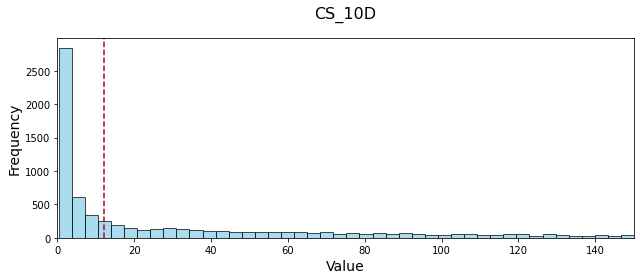

41.35900525854506


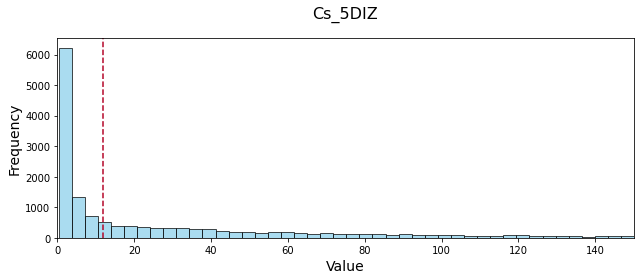

33.023798881889164


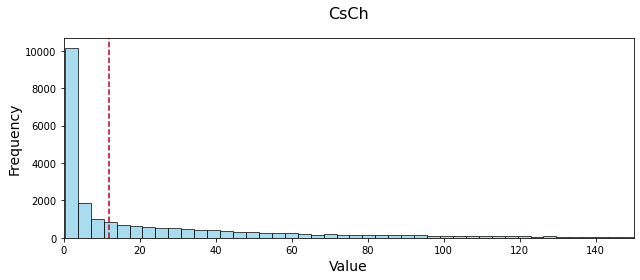

In [20]:
rec_times_treatment = {}

CONFIG_DIR = "/home/milky/sci/drosophila-isolation/configs"

def plot_times(rec_times, saddle_index, treatment):
    treatment_rec_time = (sum(rec_times) / len(rec_times))
    rec_times_seconds = list(map(lambda x: x, rec_times))
    plt.figure(figsize=(8, 4))
    plt.hist(rec_times_seconds, bins=250, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=saddle_index, color='#b40426', linestyle='--')
    plt.title(f"{treatment}", fontsize=16, pad=20)
    plt.xlabel("Value", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim(0,60)
    plt.tight_layout()
    plt.show()

rec_times = []
for TREATMENT in TREATMENTS:
    TREATMENT_CONFIG = os.path.join(CONFIG_DIR, "interaction_criteria", f"{TREATMENT}.toml")
    with open(TREATMENT_CONFIG) as f: treatment_config = toml.load(f)

    INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "2_0_find_interactions", TREATMENT)
    treatment = fileio.load_files_from_folder(INPUT_DIR)

    # rec_times = []
    for group_name, group_path in treatment.items():
        df_interactions = pd.read_csv(group_path, index_col=0)
        df_interactions = df_interactions.head(1000)
        df_interactions['start_of_interaction'] = df_interactions['start_of_interaction'] / 24
        df_interactions = df_interactions.sort_values("start_of_interaction")

        for data in df_interactions.iterrows():
            idx, values = data
            i, j, t1, end_of_interaction, _, _, _ = values

            df_j_i = df_interactions[(df_interactions['node_1'] == j) & 
                 (df_interactions['node_2'] == i) & 
                 (df_interactions['start_of_interaction'] > t1 + treatment_config['TIME'])]

            if len(df_j_i):
                j_i_edge = df_j_i.iloc[0]
                t2 = j_i_edge['start_of_interaction']

                df_i_j = df_interactions[(df_interactions['node_1'] == i) & 
                        (df_interactions['node_2'] == j) & 
                        (df_interactions['start_of_interaction'] < t2 + treatment_config['TIME'])]
                    
                if len(df_i_j):
                    if t1 == df_i_j.tail(1)['start_of_interaction'].item():
                        reciprocity_time = t2 - df_i_j.tail(1)['start_of_interaction'].item()
                        rec_times.append(reciprocity_time)
    treatment_rec_time = (sum(rec_times) / len(rec_times))
    rec_times_treatment.update({TREATMENT: round(treatment_rec_time, 2)})
    # saddle_index = 12
    print(treatment_rec_time)

    treatment_rec_time = (sum(rec_times) / len(rec_times))
    rec_times_seconds=12
    rec_times_seconds = list(map(lambda x: x, rec_times))
    plt.figure(figsize=(9, 4))
    plt.hist(rec_times_seconds, bins=250, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=12, color='#b40426', linestyle='--')
    plt.title(f"{TREATMENT}", fontsize=16, pad=20)

    plt.xlabel("Value", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim(0,150)
    plt.tight_layout()
    plt.show()


In [5]:
# pd.DataFrame(rec_times_treatment, columns='average reciprocity time')
rec_times_treatment
df_times = pd.DataFrame.from_dict(rec_times_treatment, orient='index', columns=['ave. reciprocity time (seconds)'])
df_times

,ave. reciprocity time (seconds)
CS_10D,12.30
Cs_5DIZ,6.01
CsCh,3.42


## Cycle 

```shell
    t1 i --> j
    t2 j --> k
    t3 k --> i
```

In [6]:
data = {
    'node_1': ['a', 'a', 'b', 'b', 'c', 'a', 'b', 'c'],
    'node_2': ['b', 'b', 'c', 'c', 'a', 'b', 'c', 'a'],
    'start_of_interaction': [10, 20, 100, 200, 300, 400, 500, 600]
}

df_dummy = pd.DataFrame(data)

In [7]:
# [
#     ('a', 'b', 20, 'b', 'c', 200, 'c', 'a', 300),
#     ('b', 'c', 200, 'c', 'a', 300, 'a', 'b', 400),
#     ('c', 'a', 300, 'a', 'b', 400, 'b', 'c', 500),
#     ('a', 'b', 400, 'b', 'c', 500, 'c', 'a', 600)
# ]

df_dummy

,node_1,node_2,start_of_interaction
0,a,b,10
1,a,b,20
2,b,c,100
3,b,c,200
4,c,a,300
5,a,b,400
6,b,c,500
7,c,a,600


In [8]:
def cycle_times(df):
    j_k_visited_idx = []
    k_i_visited_idx = []
    times = []
    transitive_times = []

    for data in df.iterrows():
        idx_j_k, values = data

        if idx_j_k in j_k_visited_idx:
            continue

        j, k, t1 = values
        df_k_i = df[
            (df['node_1'] == k) &
            (df['node_2'] != j) & 
            (df['start_of_interaction'] > t1 + (config['TIME'] * 24))
            ]
    
        if len(df_k_i):
            for data in df_k_i.iterrows():
                idx_k_i, values = data
                k, i, t2 = values

                if idx_k_i in k_i_visited_idx:
                    continue

                df_i_j = df[(df['node_1'] == i) &
                            (df['node_2'] == j) &
                            (df['start_of_interaction'] > t2 + (config['TIME'] * 24))]

                if len(df_i_j):
                    df_j_k_new = df[
                        (df['node_1'] == j) &
                        (df['node_2'] == k) & 
                        (df['start_of_interaction'] < t2 - (config['TIME'] * 24))
                    ]
                    t1_last = df_j_k_new.tail(1)['start_of_interaction'].item()
                                            
                    if t1_last == t1:
                        t3 = df_i_j.iloc[0]['start_of_interaction']

                        df_k_i_new = df[
                            (df['node_1'] == k) &
                            (df['node_2'] == i) & 
                            (df['start_of_interaction'] < t3 - (config['TIME'] * 24))
                        ]
                        t2_last = df_k_i_new.tail(1)['start_of_interaction'].item()

                        if t2_last == t2:
                            j_k_visited_idx.append(df_j_k_new.tail(1).index.item())
                            k_i_visited_idx.append(df_k_i_new.tail(1).index.item())

                            times.append((i, j, t1_last, j, k, t2_last, k, i, t3))
                            transitive_times.append(t3 - t1_last)

    return transitive_times

## Transitivity

```
    t1 i --> k
    t2 k --> j
    t3 i --> j
```

In [4]:
def transitivity_times(df):
    i_k_visited_idx = []
    k_j_visited_idx = []
    times = []
    transitive_times = []

    for data in df.iterrows():
        idx_i_k, values = data

        if idx_i_k in i_k_visited_idx:
            continue

        i, k, t1 = values

        df_k_j = df[
            (df['node_1'] == k) &
            (df['node_2'] != i) & 
            (df['start_of_interaction'] > t1 + (config['TIME'] * 24))
            ]
    
        if len(df_k_j):
            for data in df_k_j.iterrows():
                idx_k_j, values = data
                k, j, t2 = values

                if idx_k_j in k_j_visited_idx:
                    continue

                df_i_j = df[(df['node_1'] == i) &
                            (df['node_2'] == j) &
                            (df['start_of_interaction'] > t2 + (config['TIME'] * 24))]

                if len(df_i_j):
                    df_i_k_new = df[
                        (df['node_1'] == i) &
                        (df['node_2'] == k) & 
                        (df['start_of_interaction'] < t2 - (config['TIME'] * 24))
                    ]
                    t1_last = df_i_k_new.tail(1)['start_of_interaction'].item()
                                            
                    if t1_last == t1:
                        t3 = df_i_j.iloc[0]['start_of_interaction']

                        df_k_j_new = df[
                            (df['node_1'] == k) &
                            (df['node_2'] == j) & 
                            (df['start_of_interaction'] < t3 - (config['TIME'] * 24))
                        ]
                        t2_last = df_k_j_new.tail(1)['start_of_interaction'].item()

                        if t2_last == t2:
                            i_k_visited_idx.append(df_i_k_new.tail(1).index.item())
                            k_j_visited_idx.append(df_k_j_new.tail(1).index.item())

                            times.append((i, j, t1_last, j, k, t2_last, k, i, t3))
                            transitive_times.append(t3 - t1_last)

    return transitive_times

## Common sender closure

```
t1 k --> i
t2 k --> j
t3 i --> j
```

In [10]:
def common_sender_times(df):
    k_i_visited_idx = []
    k_j_visited_idx = []
    times = []
    transitive_times = []

    for data in df.iterrows():
        idx_k_i, values = data
        if idx_k_i in k_i_visited_idx: continue
        k, i, t1 = values

        df_k_j = df[
            (df['node_1'] == k) &
            (df['node_2'] != i) & 
            (df['start_of_interaction'] > t1 + (config['TIME'] * 24))
            ]
    
        if len(df_k_j):
            for data in df_k_j.iterrows():
                idx_k_j, values = data
                k, j, t2 = values
                if idx_k_j in k_j_visited_idx: continue

                df_i_j = df[(df['node_1'] == i) &
                            (df['node_2'] == j) &
                            (df['start_of_interaction'] > t2 + (config['TIME'] * 24))]
                if len(df_i_j):
                    df_k_i_new = df[
                        (df['node_1'] == k) &
                        (df['node_2'] == i) & 
                        (df['start_of_interaction'] < t2 - (config['TIME'] * 24))
                    ]
                    t1_last = df_k_i_new.tail(1)['start_of_interaction'].item()
                                            
                    if t1_last == t1:
                        t3 = df_i_j.iloc[0]['start_of_interaction']
                        df_k_j_new = df[
                            (df['node_1'] == k) &
                            (df['node_2'] == j) & 
                            (df['start_of_interaction'] < t3 - (config['TIME'] * 24))
                        ]
                        t2_last = df_k_j_new.tail(1)['start_of_interaction'].item()

                        if t2_last == t2:
                            k_i_visited_idx.append(df_k_i_new.tail(1).index.item())
                            k_j_visited_idx.append(df_k_j_new.tail(1).index.item())
                            times.append((i, j, t1_last, j, k, t2_last, k, i, t3))
                            transitive_times.append(t3 - t1_last)

    return transitive_times

## Common reciver closure

```
    t1 i --> k
    t2 j --> k
    t3 i --> j
```

In [11]:
def common_reciver_times(df):
    i_k_visited_idx = []
    j_k_visited_idx = []
    times = []
    transitive_times = []

    for data in df.iterrows():
        idx_i_k, values = data

        if idx_i_k in i_k_visited_idx:
            continue

        i, k, t1 = values

        df_j_k = df[
            (df['node_1'] != i) &
            (df['node_2'] == k) & 
            (df['start_of_interaction'] > t1 + (config['TIME'] * 24))
            ]
    
        if len(df_j_k):
            for data in df_j_k.iterrows():
                idx_k_j, values = data
                j, k, t2 = values

                if idx_k_j in j_k_visited_idx:
                    continue

                df_i_j = df[(df['node_1'] == i) &
                            (df['node_2'] == j) &
                            (df['start_of_interaction'] > t2 + (config['TIME'] * 24))]

                if len(df_i_j):
                    df_i_k_new = df[
                        (df['node_1'] == i) &
                        (df['node_2'] == k) & 
                        (df['start_of_interaction'] < t2 - (config['TIME'] * 24))
                    ]
                    t1_last = df_i_k_new.tail(1)['start_of_interaction'].item()
                                            
                    if t1_last == t1:
                        t3 = df_i_j.iloc[0]['start_of_interaction']

                        df_j_k_new = df[
                            (df['node_1'] == j) &
                            (df['node_2'] == k) & 
                            (df['start_of_interaction'] < t3 - (config['TIME'] * 24))
                        ]
                        t2_last = df_j_k_new.tail(1)['start_of_interaction'].item()

                        if t2_last == t2:
                            i_k_visited_idx.append(df_i_k_new.tail(1).index.item())
                            j_k_visited_idx.append(df_j_k.tail(1).index.item())

                            times.append((i, j, t1_last, j, k, t2_last, k, i, t3))
                            transitive_times.append(t3 - t1_last)

    return transitive_times

CS_10D 3014.0675


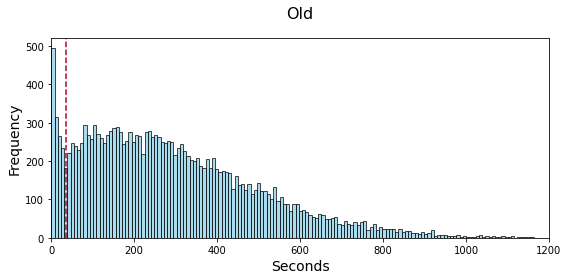

Cs_5DIZ 14759.7625


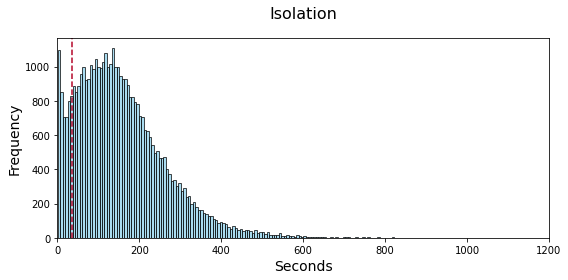

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def find_saddle(list_of_lists):
    big_array = np.concatenate(list_of_lists)
    counts, bin_edges = np.histogram(big_array, bins=200, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    smoothed_counts = gaussian_filter1d(counts, sigma=2)
    peaks, _ = find_peaks(smoothed_counts)
    valleys, _ = find_peaks(-smoothed_counts)
    saddle_index = None
    saddle_index = valleys[1]

    return bin_centers[saddle_index]


def cycle_process_group(group_path):
    df = pd.read_csv(group_path, usecols=['node_1', 'node_2', 'start_of_interaction'])
    df = df.sort_values("start_of_interaction")
    res = cycle_times(df)
    
    return res


def transitivity_process_group(group_path):
    df = pd.read_csv(group_path, usecols=['node_1', 'node_2', 'start_of_interaction'])
    df = df.sort_values("start_of_interaction")
    res = transitivity_times(df)

    return res


def common_sender_process_group(group_path):
    df = pd.read_csv(group_path, usecols=['node_1', 'node_2', 'start_of_interaction'])
    df = df.sort_values("start_of_interaction")
    res = common_sender_times(df)
    
    return res


def common_reciver_process_group(group_path):
    df = pd.read_csv(group_path, usecols=['node_1', 'node_2', 'start_of_interaction'])
    df = df.sort_values("start_of_interaction")
    res = common_reciver_times(df)
    
    return res


cycle_times_treatment = {}
for TREATMENT in TREATMENTS:
    # print(TREATMENT)
    CONFIG_DIR = "/home/milky/sci/drosophila-isolation/configs"
    TREATMENT_CONFIG = os.path.join(CONFIG_DIR, "interaction_criteria", f"{TREATMENT}.toml")

    with open(TREATMENT_CONFIG) as f: config = toml.load(f)
    INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "2_0_find_interactions", TREATMENT)
    treatment = fileio.load_files_from_folder(INPUT_DIR)

    with ProcessPoolExecutor() as executor:
        # cycle_results = list(executor.map(cycle_process_group, treatment.values()))
        transitivity_results = list(executor.map(transitivity_process_group, treatment.values()))
        # common_sender_results = list(executor.map(common_sender_process_group, treatment.values()))
        # common_reciver_results = list(executor.map(common_reciver_process_group, treatment.values()))


    saddle_index= find_saddle(transitivity_results)
    print(TREATMENT, saddle_index)
    big_array = np.concatenate(transitivity_results)

    rec_times = big_array/24

    treatment_rec_time = (sum(rec_times) / len(rec_times))
    rec_times_seconds = list(map(lambda x: x, rec_times))
    plt.figure(figsize=(8, 4))
    plt.hist(rec_times_seconds, bins=150, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=36, color='#b40426', linestyle='--')
    plt.title(f"{renamed_treatments[TREATMENT]}", fontsize=16, pad=20)
    plt.xlabel("Seconds", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim(0,1200)
    # plt.xlim(0,1200)
    plt.tight_layout()

    plt.savefig(f'figures/{renamed_treatments[TREATMENT]}_transitivity.svg', dpi=500)
    plt.savefig(f'figures/{renamed_treatments[TREATMENT]}_transitivity.png', dpi=500)

    plt.show()
    # sys.exit()

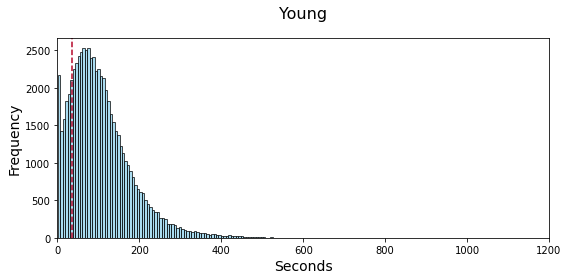

In [30]:
plt.figure(figsize=(8, 4))
plt.hist(rec_times_seconds, bins=150, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=36, color='#b40426', linestyle='--')
plt.title(f"{renamed_treatments[TREATMENT]}", fontsize=16, pad=20)
plt.xlabel("Seconds", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim(0,1200)
# plt.xlim(0,1200)
plt.tight_layout()

plt.savefig(f'figures/{renamed_treatments[TREATMENT]}_transitivity.svg', dpi=500)
plt.savefig(f'figures/{renamed_treatments[TREATMENT]}_transitivity.png', dpi=500)

plt.show()